In [2]:
from seinfeld_playground import *
from train_utils import split_train_test
from compare_models import plot_confusion_matrix, compare_models_roc_curve
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
df = load_corpus()

df = getSceneData(df)
print("There are %d sentances, %d funny, %d not funny" % (len(df), sum(df.is_funny), len(df) - sum(df.is_funny)))
df.head(2)

There are 46497 sentances, 13560 funny, 32937 not funny


,character,end,episode_name,episode_num,is_funny,laugh_time,length,line_num,num_words,season,...,total_lines,txt,global_episode_num,time_from_prev,new_scene,scene_text,scene_characters,n_scene_characters,scene_number_in_episode,global_scene_number
0,JERRY,3.050,The Watch,6,True,3.6,1.944,0,9,4,...,486,"Here's what happened last week, incase you mi...",1,0.000,True,"Here's what happened last week, incase you mi...","{MORTY, JERRY}",2,1,1
1,JERRY,6.371,The Watch,6,False,NaN,3.297,1,16,4,...,486,"George and I went up to NBC, and we told them...",1,0.024,False,"Here's what happened last week, incase you mi...","{MORTY, JERRY}",2,1,1


In [4]:
len(df.global_episode_num.unique())

96

In [7]:
df_train, df_test = split_train_test(df, 0.2)
df_train.shape, df_test.shape

((37738, 22), (8759, 22))

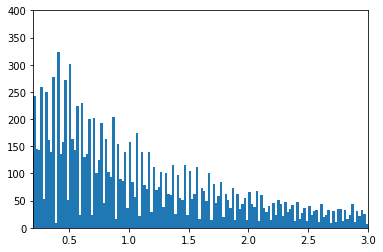

In [8]:
plt.hist(df['time_from_prev'], bins=([i / 100 for i in range(0,302,2)]) + ([10,30,50,100]))
plt.xlim(0.2,3)
plt.ylim(0,400)
plt.show()

Try to decide on thershold, it's pretty hard.  
I preffer not to have FP so Will pick 1.8

In [9]:
df_kramer_start = df[(df.character == 'KRAMER') & (df.new_scene)] 
print('kramer first in secnce funny: ', sum(df_kramer_start.is_funny) / len(df_kramer_start))
print('total funny:', sum(df.is_funny) / len(df))

kramer first in secnce funny:  0.36054421768707484
total funny: 0.29163171817536615


# One Hot Encoding

In [10]:
cv, X_train = getOneHotEncoding(df_train.txt)
X_test = cv.transform(df_test.txt)
y_test = df_test.is_funny
y_train = df_train.is_funny

## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
y_hat_lr = lr.predict_proba(X_test)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [21]:
1588 / (3136 + 1588)

0.336155800169348

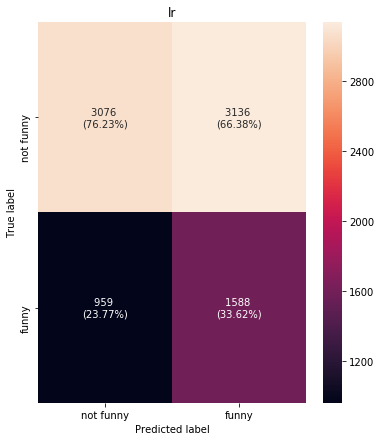

In [20]:
plot_confusion_matrix(y_test, [y_hat_lr[:,1]], ['lr'])

## SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(probability=1, gamma='auto')
svm.fit(X_train, y_train)
y_hat_svm = svm.predict_proba(X_test)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_hat_lr[:,1] > 0.22)

In [ ]:
funny_words = np.squeeze(np.asarray((freq[np.array(df.is_funny).astype(np.bool)].sum(axis=0)) / (np.squeeze(np.asarray(freq.sum(axis=0)).astype(np.float)))))

# Compare Models

In [ ]:
from compare_models import compare_models_roc_curve
auc = compare_models_roc_curve(y_test, [y_hat_lr[:,1], y_hat_svm[:,1]], ['lr', 'svm'])
print(auc)

In [ ]:
plot_confusion_matrix(y_test, [y_hat_lr[:,1], y_hat_svm[:,1]], ['lr', 'svm'])

# Scene

In [42]:
import networkx as nx
import itertools
from bokeh.io import show, output_notebook, reset_output #output_file, 
from bokeh.plotting import figure
from bokeh.models.graphs import from_networkx
from bokeh.models import HoverTool,BoxZoomTool, ResetTool, Plot, Range1d
# reset_output()
output_notebook()



Loading BokehJS ...

In [8]:
community_df = df[['scene_number_in_episode', 'global_scene_number', 'scene_characters', 'is_funny', 'season']]
community_df.head()

,scene_number_in_episode,global_scene_number,scene_characters,is_funny,season
0,1,1,"{MORTY, JERRY}",True,4
1,1,1,"{MORTY, JERRY}",False,4
2,1,1,"{MORTY, JERRY}",False,4
3,1,1,"{MORTY, JERRY}",False,4
4,1,1,"{MORTY, JERRY}",False,4


In [18]:
# add for each scene is the scene funny
funny_scene_df = pd.DataFrame(community_df.groupby(by='global_scene_number')['is_funny'].sum() > 0)
def add_funny_scecne(x, df):
    return [x.is_funny] * sum(df.global_scene_number == x.name)
funny_scene_ls = funny_scene_df.apply(add_funny_scecne, args=(community_df,), axis=1)
funny_scene = [st for row in funny_scene_ls for st in row]
community_df['is_scene_funny'] = funny_scene
community_df.head()

/home/yuval/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,scene_number_in_episode,global_scene_number,scene_characters,is_funny,season,is_scene_funny
0,1,1,"{MORTY, JERRY}",True,4,True
1,1,1,"{MORTY, JERRY}",False,4,True
2,1,1,"{MORTY, JERRY}",False,4,True
3,1,1,"{MORTY, JERRY}",False,4,True
4,1,1,"{MORTY, JERRY}",False,4,True


In [25]:
graph = []
for idx, row in community_df.iterrows():
#     print(row['scene_characters'])
    if len(row['scene_characters']) > 1:
        for comb in list(itertools.combinations(row['scene_characters'], 2)):
            # sort by abc so always same order
            char_1, char_2 = sorted(comb)
            graph.append({'char_1' : char_1, 'char_2' : char_2, **row.drop('scene_characters').to_dict()})
#         graph.append()
df_graph = pd.DataFrame(graph)
df_graph.head()

,char_1,char_2,global_scene_number,is_funny,is_scene_funny,scene_number_in_episode,season
0,JERRY,MORTY,1,True,True,1,4
1,JERRY,MORTY,1,False,True,1,4
2,JERRY,MORTY,1,False,True,1,4
3,JERRY,MORTY,1,False,True,1,4
4,JERRY,MORTY,1,False,True,1,4


In [26]:
# Create the graph
g = nx.from_pandas_edgelist(df_graph[:100], source='char_1', target='char_2', edge_attr='is_funny')
pos=nx.fruchterman_reingold_layout(g) 

In [ ]:
import networkx as nx
import itertools
from bokeh.io import show, output_notebook, reset_output #output_file, 
from bokeh.plotting import figure
from bokeh.models.graphs import from_networkx
from bokeh.models import HoverTool,BoxZoomTool, ResetTool, Plot, Range1d
# reset_output()
# output_notebook()



In [80]:
weight_graph = df_graph[['char_1', 'char_2']].drop_duplicates()
weight_graph = weight_graph.set_index(['char_1', 'char_2'])
weight_graph['weight'] = df_graph.groupby(['char_1', 'char_2']).size()
weight_graph.reset_index(inplace=True)
weight_graph.head()

,char_1,char_2,weight
0,JERRY,MORTY,875
1,HELEN,MORTY,838
2,HELEN,JERRY,919
3,MORTY,SUSAN,56
4,GEORGE,MORTY,489


In [113]:

g = nx.from_pandas_edgelist(weight_graph, source='char_1', target='char_2', 
                            edge_attr='weight')
plot = figure(title="senfiled charcters scenes", x_range=(-2.1,2.1), 
              y_range=(-2.1,2.1), tools="pan,box_select")


pos = nx.spring_layout
graph = from_networkx(g, pos, scale=2, center=(0,0))

edge_weight = np.array([g.get_edge_data(a,b)['weight'] for a, b in g.edges()])
edge_weight = edge_weight * 100 / np.sum(edge_weight)

# nx.draw_networkx_edges(g, pos, width=edge_weight)
graph.edge_renderer.data_source.data["line_width"] = edge_weight

graph.edge_renderer.glyph.line_width = {'field': 'line_width'}

# edge_attrs = {}

node_hover_tool = HoverTool(tooltips=[("name", "@index")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())

# for start_node, end_node, _ in g.edges(data=True):
#     print(start_node)
#     print(end_node)
#     edge_color = SAME_CLUB_COLOR if G.nodes[start_node]["club"] == G.nodes[end_node]["club"] else DIFFERENT_CLUB_COLOR
#     edge_attrs[(start_node, end_node)] = edge_color

plot.renderers.append(graph)
show(plot)

In [96]:
np.max(edge_weight)

17186

In [138]:
import itertools
def scene_chars(x, df):
    cur_df = pd.DataFrame()
    for comb in list(itertools.combinations(df.loc['scene_characters'], 2)):
        
    
# create dataframe with graph layout
community_df.apply(lambda x: )

[('HELEN', 'JERRY'), ('HELEN', 'MORTY'), ('JERRY', 'MORTY')]

In [23]:
for i in sorted(df.n_scene_characters.unique()):
    print('scene with %d charcters funny precentage: ' % i, sum(df[(df.n_scene_characters == i)].is_funny) / len(df[(df.n_scene_characters == i)]), 'amount: ', len(df[(df.n_scene_characters == i)]))
print('total funny:', sum(df.is_funny) / len(df))

scene with 1 charcters funny precentage:  0.5032030749519538 amount:  3122
scene with 2 charcters funny precentage:  0.2943139678615575 amount:  16180
scene with 3 charcters funny precentage:  0.27437231395611855 amount:  13263
scene with 4 charcters funny precentage:  0.259865005192108 amount:  7704
scene with 5 charcters funny precentage:  0.2531400966183575 amount:  3105
scene with 6 charcters funny precentage:  0.25443425076452597 amount:  1635
scene with 7 charcters funny precentage:  0.25895598771750256 amount:  977
scene with 8 charcters funny precentage:  0.2864864864864865 amount:  185
scene with 9 charcters funny precentage:  0.22510822510822512 amount:  231
scene with 10 charcters funny precentage:  0.2736842105263158 amount:  95
total funny: 0.29163171817536615


In [24]:
# Add to the df
df['scence_text'] = [text_for_scene[i] for i in range(len(number_rows_scence)) for _ in range(number_rows_scence[i])]
df['scence_charcteres'] = [charcteres_scence[i] for i in range(len(number_rows_scence)) for _ in range(number_rows_scence[i])]
df['n_scence_charcteres'] = df.scence_charcteres.str.len()

NameError: name 'number_rows_scence' is not defined

In [ ]:
from seinfeld_laugh_corpus import corpus
seinfeld = corpus.load(fold_laughs=True)

In [ ]:
a = seinfeld.screenplays[0]

# Plots

In [ ]:
df.n_scene_characters

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


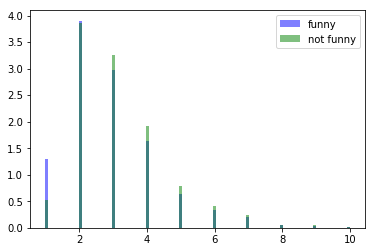

In [7]:
plt.hist(df[df.is_funny].n_scene_characters, bins=100, alpha=0.5, color='b', label='funny', normed=1)
plt.hist(df[~df.is_funny].n_scene_characters, bins=100, alpha=0.5, color='g', label='not funny', normed=1)
plt.legend()
plt.show()

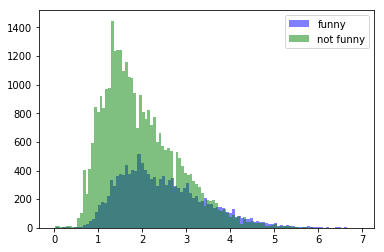

In [25]:
plt.hist(df[df.is_funny].length, bins=100, alpha=0.5, color='b', label='funny')
plt.hist(df[~df.is_funny].length, bins=100, alpha=0.5, color='g', label='not funny')
plt.legend()
plt.show()

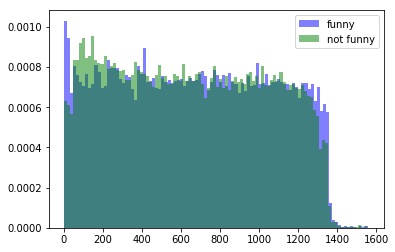

In [26]:
plt.hist(df[df.is_funny].start, bins=100, alpha=0.5, color='b', label='funny', density=1)
plt.hist(df[~df.is_funny].start, bins=100, alpha=0.5, color='g', label='not funny', density=1)
plt.legend()
plt.show()

In [27]:
g = sns.FacetGrid(df, col='character', row='is_funny')
g.map(sns.distplot, "start", bins=50, color='b')
plt.show()

ValueError: Image size of 124416x432 pixels is too large. It must be less than 2^16 in each direction.

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd2f4c147b8> (for post_execute):


ValueError: Image size of 124416x432 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 124416x432 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 124416x432 with 1152 Axes>

In [ ]:
g = sns.FacetGrid(df, col='character', row='is_funny')
g.map(sns.distplot, "length", bins=50, color='b')
plt.show()

ValueError: Image size of 124416x432 pixels is too large. It must be less than 2^16 in each direction.

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fea4fbf9bf8> (for post_execute):


ValueError: Image size of 124416x432 pixels is too large. It must be less than 2^16 in each direction.

In [ ]:
g = sns.FacetGrid(df, col='character', row='is_funny')
g.map(sns.distplot, "season", bins=50, color='b')
plt.show()

In [ ]:
g = sns.FacetGrid(df[df['character'].isin(["JERRY", "ELAINE", "KRAMER", "GEORGE"])], col='character', row='is_funny')
g.map(sns.distplot, "start", bins=50, color='b')
plt.show()

In [ ]:
g2 = sns.FacetGrid(df, col='character', row='is_funny')
g2.map(sns.distplot, "num_words", bins=50, color='b')
plt.show()